In [20]:
# ライブラリのインポート
import pandas as pd
import numpy as np
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split


cali_housing = fetch_california_housing(as_frame=True)
#x=cali_housing.data
#y=cali_housing.target

df=cali_housing.frame

###外れ値処理(多変量連関図で確認しながら標準偏差で外れ値を処理)
ar_std=df['AveRooms'].std()
ab_std=df['AveBedrms'].std()
pop_std=df['Population'].std()
ao_std=df['AveOccup'].std()

ar_mean=df['AveRooms'].mean()
ab_mean=df['AveBedrms'].mean()
pop_mean=df['Population'].mean()
ao_mean=df['AveOccup'].mean()

limit_low=ar_mean - 1*ab_std
limit_high=ar_mean + 1*ab_std

limit_low1=ab_mean - 1*ab_std
limit_high1=ab_mean + 1*ab_std

limit_low2=pop_mean - 1*pop_std
limit_high2=pop_mean + 1*pop_std

limit_low3=ao_mean - 0.5*ao_std
limit_high3=ao_mean + 0.5*ao_std

newdf=df.query('@limit_low < AveRooms < @limit_high')
newdf1=newdf.query('@limit_low1 < AveBedrms < @limit_high1')
newdf2=newdf1.query('@limit_low2 < Population < @limit_high2')
newdf3=newdf2.query('@limit_low3 < AveOccup < @limit_high3')

#正規化(Max-Min法)
def minmax_norm(df):
    return (df - df.min()) / ( df.max() - df.min())

df_minmax_norm = minmax_norm(newdf3)
#入力因子をxに代入
x=df_minmax_norm.iloc[:,:8]
#出力因子をyに代入
y=df_minmax_norm.iloc[:,8:9]

#全体データから未知データを生成
x_know,x_unknown,y_know,y_unknown=train_test_split(x,y,test_size=0.2)
#既知データから訓練データとテストデータに分割
x_train,x_test,y_train,y_test=train_test_split(x_know,y_know,test_size=0.2)

Training - Epoch [10/100], Loss: 0.0266
Validation - Epoch [10/100], Loss: 0.0425
Training - Epoch [20/100], Loss: 0.0187
Validation - Epoch [20/100], Loss: 0.0412
Training - Epoch [30/100], Loss: 0.0125
Validation - Epoch [30/100], Loss: 0.0201
Training - Epoch [40/100], Loss: 0.0272
Validation - Epoch [40/100], Loss: 0.0147
Training - Epoch [50/100], Loss: 0.0218
Validation - Epoch [50/100], Loss: 0.0144
Training - Epoch [60/100], Loss: 0.0085
Validation - Epoch [60/100], Loss: 0.0141
Training - Epoch [70/100], Loss: 0.0050
Validation - Epoch [70/100], Loss: 0.0139
Training - Epoch [80/100], Loss: 0.0053
Validation - Epoch [80/100], Loss: 0.0146
Training - Epoch [90/100], Loss: 0.0040
Validation - Epoch [90/100], Loss: 0.0146
Training - Epoch [100/100], Loss: 0.0053
Validation - Epoch [100/100], Loss: 0.0135


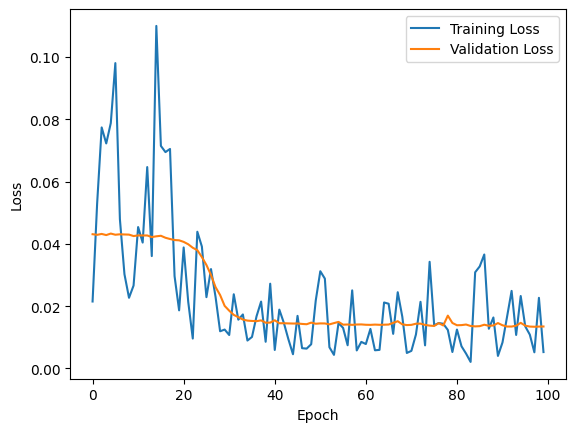

In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# ランダムシードの設定
fix_seed = 2024
np.random.seed(fix_seed)
torch.manual_seed(fix_seed)


# データをPyTorchのTensorに変換
train_x = torch.FloatTensor(x_train.values)
train_y = torch.FloatTensor(y_train.values)

val_x = torch.FloatTensor(x_test.values)
val_y = torch.FloatTensor(y_test.values)

# GPUが利用可能ならGPUを使う
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# データセットとデータローダーの作成
dataset = TensorDataset(train_x, train_y)
dataloader = DataLoader(dataset, batch_size=10, shuffle=True)
valdataset = TensorDataset(val_x, val_y)
valdataloader = DataLoader(valdataset, batch_size=10, shuffle=True)





# モデルの定義
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.regression = nn.Sequential(
            nn.Linear(8, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 64),
            nn.ReLU(inplace=True),
            nn.Linear(64, 32),
            nn.ReLU(inplace=True),
            nn.Linear(32, 16),
            nn.ReLU(inplace=True),
            nn.Linear(16, 8),
            nn.ReLU(inplace=True),
            nn.Linear(8, 1)
        )

    def forward(self, x):
        output = self.regression(x)
        return output

# モデル、損失関数、オプティマイザの初期化
model = MLP().to(device)
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# トレーニングループ
num_epochs = 100
train_losses = []  # トレーニングの損失を保存するリスト
val_losses = []    # 検証の損失を保存するリスト

for epoch in range(num_epochs):
    model.train()  # モデルをトレーニングモードに切り替え
    for batch_x, batch_y in dataloader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        optimizer.zero_grad()
        output = model(batch_x)
        loss = criterion(output, batch_y)
        loss.backward()
        optimizer.step()
    train_losses.append(loss.item())

    # 10エポックごとに損失を表示
    if (epoch + 1) % 10 == 0:
        print(f'Training - Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

    # 検証ループ
    model.eval()  # モデルを評価モードに切り替え
    with torch.no_grad():
        val_loss = 0
        for val_batch_x, val_batch_y in valdataloader:
            val_batch_x, val_batch_y = val_batch_x.to(device), val_batch_y.to(device)
            val_output = model(val_batch_x)
            val_loss += criterion(val_output, val_batch_y).item()
        val_loss /= len(valdataloader)
        val_losses.append(val_loss)

        # 10エポックごとに検証の損失を表示
        if (epoch + 1) % 10 == 0:
            print(f'Validation - Epoch [{epoch+1}/{num_epochs}], Loss: {val_loss:.4f}')

# TrainとValのLossをプロット
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


### TIPS
Loss関数にMAEを使用するとき
~~~python
criterion = nn.L1Loss() #MAE
~~~

Loss関数にRMSEを使用するとき
~~~python
class RMSELoss(nn.Module):
    def __init__(self):
        super(RMSELoss, self).__init__()
        self.mse = nn.MSELoss()

    def forward(self, yhat, y):
        return torch.sqrt(self.mse(yhat, y))

criterion = RMSELoss()
~~~

最適化アルゴリズムにAdamを使用するとき

~~~python
optimizer = optim.Adam(model.parameters(), lr=0.001)
~~~


# 推論

RMSE: 0.1130700632929802


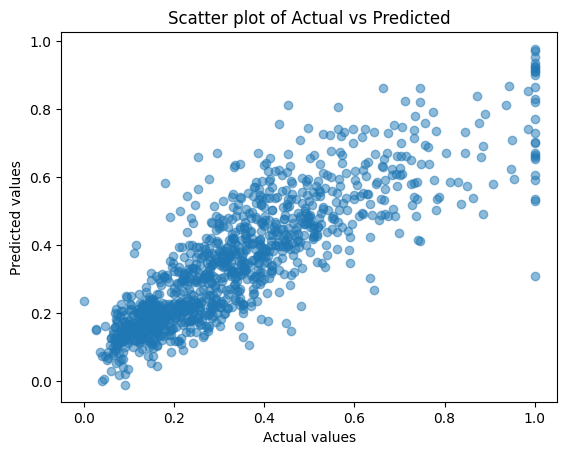

In [22]:
x_un = torch.FloatTensor(x_unknown.values)
y_un = torch.FloatTensor(y_unknown.values)

# モデルを評価モードに切り替え
model.eval()

# 予測
x_un = x_un.to(device)
predicted_output = model(x_un)
pre_result = predicted_output.cpu().detach().numpy()

# RMSEの計算
rmse = np.sqrt(mean_squared_error(y_un, pre_result))
print(f'RMSE: {rmse}')

# 散布図のプロット
plt.scatter(y_un, pre_result, alpha=0.5)
plt.title('Scatter plot of Actual vs Predicted')
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.show()

# Tensorflowで記述した場合

Epoch 1/100
354/354 [==============================] - 3s 5ms/step - loss: 0.0454 - val_loss: 0.0334
Epoch 2/100
354/354 [==============================] - 1s 4ms/step - loss: 0.0276 - val_loss: 0.0200
Epoch 3/100
354/354 [==============================] - 2s 4ms/step - loss: 0.0191 - val_loss: 0.0166
Epoch 4/100
354/354 [==============================] - 2s 6ms/step - loss: 0.0165 - val_loss: 0.0158
Epoch 5/100
354/354 [==============================] - 2s 4ms/step - loss: 0.0156 - val_loss: 0.0151
Epoch 6/100
354/354 [==============================] - 2s 5ms/step - loss: 0.0150 - val_loss: 0.0146
Epoch 7/100
354/354 [==============================] - 1s 4ms/step - loss: 0.0146 - val_loss: 0.0144
Epoch 8/100
354/354 [==============================] - 2s 4ms/step - loss: 0.0143 - val_loss: 0.0143
Epoch 9/100
354/354 [==============================] - 1s 4ms/step - loss: 0.0140 - val_loss: 0.0143
Epoch 10/100
354/354 [==============================] - 2s 4ms/step - loss: 0.0141 - val_lo

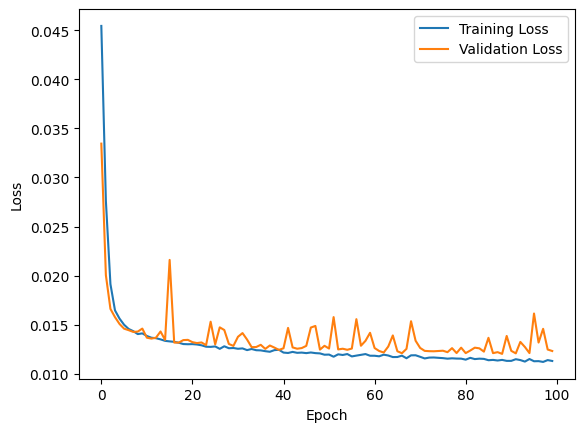

In [23]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
import numpy as np
import matplotlib.pyplot as plt

# ランダムシードの設定
fix_seed = 2024
np.random.seed(fix_seed)
# TensorFlowのランダムシードの固定
tf.random.set_seed(fix_seed)

# モデルの定義
class MLP(tf.keras.Model):
    def __init__(self):
        super(MLP, self).__init__()
        self.regression = models.Sequential([
            layers.Dense(128, activation='relu'),
            layers.Dense(64, activation='relu'),
            layers.Dense(32, activation='relu'),
            layers.Dense(16, activation='relu'),
            layers.Dense(8, activation='relu'),
            layers.Dense(1)
        ])

    def call(self, x):
        return self.regression(x)

# GPU上でモデルを構築
with tf.device('/GPU:0'):
    model_tf = MLP()

# モデル、損失関数、オプティマイザの初期化
criterion = tf.keras.losses.MeanSquaredError()
optimizer = optimizers.SGD(learning_rate=0.01)

# データセットの作成
train_dataset = tf.data.Dataset.from_tensor_slices((train_x, train_y))
train_dataset = train_dataset.shuffle(buffer_size=len(train_x)).batch(10)
val_dataset = tf.data.Dataset.from_tensor_slices((val_x, val_y)).batch(10)

# モデルのコンパイル
model_tf.compile(optimizer=optimizer, loss=criterion)

# トレーニング
hist = model_tf.fit(train_dataset,
                    epochs=100,
                    validation_data=val_dataset,
                    verbose=1)

# トレーニングと検証の損失履歴を取得
train_losses = hist.history['loss']
val_losses = hist.history['val_loss']

# TrainとValのLossをプロット
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


# Tensorflowでの推論

RMSE: 0.10935690253973007


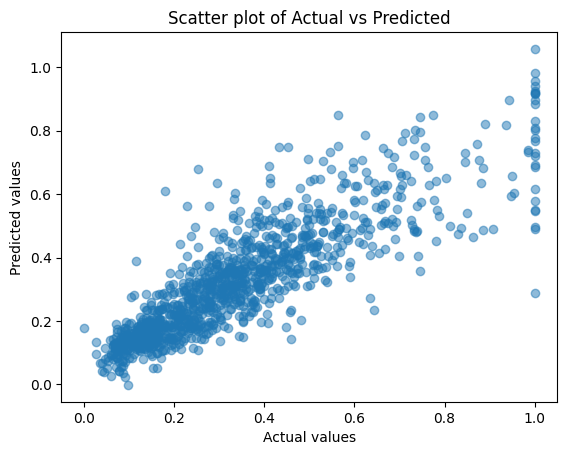

In [24]:
import tensorflow as tf
import numpy as np
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# 未知データをテンソルに変換
x_un_tf = tf.constant(x_unknown.values, dtype=tf.float32)
y_un_tf = tf.constant(y_unknown.values, dtype=tf.float32)


# TensorFlowモデルの予測
predicted_output_tf = model_tf(x_un_tf, training=False)
pre_result_tf = predicted_output_tf.numpy()

# RMSEの計算
rmse_tf = np.sqrt(mean_squared_error(y_un_tf, pre_result_tf))
print(f'RMSE: {rmse_tf}')

# 散布図のプロット
plt.scatter(y_un_tf, pre_result_tf, alpha=0.5)
plt.title('Scatter plot of Actual vs Predicted')
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.show()